In [1]:
import json
from collections import defaultdict

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

2025-01-23 14:07:16.261811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with open('../sample-data/fullsample.jsonl', 'r') as f:
    graph_lines = f.readlines()

In [3]:
def as_deployments(graph_entry):
    podToDep = dict()
    depData = defaultdict(list)
    cost = 0
    new_entry = dict()
    for n in graph_entry['nodes']:
        cost += 1
        podToDep[n['id']] = n['deployment']
        depData[n['deployment']].append({'queue_size': n['metrics']['metrics']['queue_size'], 'queue_use': n['metrics']['metrics']['queue_use']})
    
    newNodes = []
    for (key, value) in depData.items():
        new_entry[key] = {'queue_size': 0, 'queue_use': 0, 'replicas': 0}
        for n in value:
            new_entry[key]['replicas'] += 1
            for k, v in n.items():
                new_entry[key][k] += v
        # newNodes.append(node)
    
    # edgeSet = set()
    # for e in graph_entry['edges']:
        # e['source'] = podToDep[e['source']]
#         e['target'] = podToDep[e['target']]
#         edgeSet.add(json.dumps(e))
    #graph_entry['edges'] = [json.loads(e) for e in edgeSet]
    # graph_entry['nodes'] = newNodes
    # graph_entry['network_data']['network_cost'] = cost
    new_entry['total_rejected'] = graph_entry['network_data']['total_rejected']
    return new_entry

In [4]:
as_deployments(json.loads(graph_lines[-1]))

{'service-9': {'queue_size': 36, 'queue_use': 34, 'replicas': 3},
 'service-2': {'queue_size': 15, 'queue_use': 0, 'replicas': 3},
 'service-8': {'queue_size': 14, 'queue_use': 14, 'replicas': 2},
 'service-4': {'queue_size': 12, 'queue_use': 0, 'replicas': 1},
 'service-13': {'queue_size': 42, 'queue_use': 0, 'replicas': 3},
 'service-5': {'queue_size': 15, 'queue_use': 0, 'replicas': 3},
 'service-0': {'queue_size': 28, 'queue_use': 28, 'replicas': 2},
 'service-7': {'queue_size': 27, 'queue_use': 15, 'replicas': 3},
 'service-3': {'queue_size': 20, 'queue_use': 0, 'replicas': 2},
 'service-6': {'queue_size': 26, 'queue_use': 0, 'replicas': 2},
 'service-11': {'queue_size': 6, 'queue_use': 6, 'replicas': 1},
 'service-10': {'queue_size': 16, 'queue_use': 15, 'replicas': 2},
 'service-12': {'queue_size': 14, 'queue_use': 13, 'replicas': 1},
 'service-1': {'queue_size': 33, 'queue_use': 0, 'replicas': 3},
 'total_rejected': 22}

In [5]:
data = pd.json_normalize(
    [
        as_deployments(json.loads(entry))
        for entry in graph_lines
    ])
results = data.pop('total_rejected')

In [6]:
results

0        0
1        0
2       11
3       12
4       12
        ..
3582    20
3583    20
3584    21
3585    20
3586    22
Name: total_rejected, Length: 3587, dtype: int64

In [7]:
data_train, data_test, labels_train, labels_test = train_test_split(data, results, test_size=0.2, random_state=42)

In [8]:
def plot(histories):
    epochs = range(1, len(histories[0]['loss'])+1)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    for i in range(len(histories)):
        history = histories[i]
        if i == 0:
            plt.plot(epochs, history['mean_absolute_error'], 'b', label='Erro médio absoluto de treino')
        else:
            plt.plot(epochs,history['mean_absolute_error'], 'b')
        if i == 0:
            plt.plot(epochs, history['val_mean_absolute_error'], 'r--', label='Erro médio absoluto de validação')
        else:
            plt.plot(epochs, history['val_mean_absolute_error'], 'r--')

    plt.title(f'Erros empírico e de validação')
    plt.xlabel('Epochs')
    plt.ylabel('Erro')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def train_kfold(model, data_train, labels_train, epochs, batch_size):
    histories = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_i, validate_i in kf.split(data_train):
        data_train_fold, data_train_validation = data_train.iloc[train_i], data_train.iloc[validate_i]
        labels_train_fold, labels_train_validation = labels_train.iloc[train_i], labels_train.iloc[validate_i]

        history = model.fit(data_train_fold, labels_train_fold, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(data_train_validation, labels_train_validation))
        histories.append(history.history)

    return model, histories

In [10]:
model = models.Sequential([
    layers.Dense(10, activation='relu', input_shape=(data_train.shape[1],)),
    layers.Dense(10, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/Users/henriquefurst/.asdf/installs/python/3.11.3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 313.6447 - mean_absolute_error: 17.0671 - val_loss: 117.6399 - val_mean_absolute_error: 10.1503
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.8330 - mean_absolute_error: 6.8717 - val_loss: 21.9779 - val_mean_absolute_error: 3.6189
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9025 - mean_absolute_error: 3.3717 - val_loss: 20.5783 - val_mean_absolute_error: 3.4844
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.2375 - mean_absolute_error: 3.2349 - val_loss: 19.8490 - val_mean_absolute_error: 3.4064
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.6135 - mean_absolute_error: 3.2558 - val_loss: 19.0628 - val_mean_absolute_error: 3.3344
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8265 - mean_absolute_error: 3.1873 - val_loss: 18.3195 - val_mean_absolute_error: 3.2716
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.9891 - mean_absolute_error: 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0398 - mean_absolute_error: 2.4092 - val_loss: 10.6305 - val_mean_absolute_error: 2.4917
Epoch 46/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1382 - mean_absolute_error: 2.3293 - val_loss: 10.8526 - val_mean_absolute_error: 2.5369
Epoch 47/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2132 - mean_absolute_error: 2.2975 - val_loss: 10.7169 - val_mean_absolute_error: 2.4911
Epoch 48/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8736 - mean_absolute_error: 2.3469 - val_loss: 10.4237 - val_mean_absolute_error: 2.4669
Epoch 49/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6693 - mean_absolute_error: 2.3306 - val_loss: 10.5752 - val_mean_absolute_error: 2.5094
Epoch 50/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2427 - mean_absolute_error: 2.2971 - val_loss: 10.3142 - val_mean_absolute_error: 2.4526
Epoch 51/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5087 - mean_absolute_error: 2.3320 - val_los

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7338 - mean_absolute_error: 2.2367 - val_loss: 9.6263 - val_mean_absolute_error: 2.3842
Epoch 90/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4323 - mean_absolute_error: 2.1839 - val_loss: 9.7736 - val_mean_absolute_error: 2.4126
Epoch 91/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5936 - mean_absolute_error: 2.2133 - val_loss: 9.6351 - val_mean_absolute_error: 2.3815
Epoch 92/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4177 - mean_absolute_error: 2.2125 - val_loss: 9.7901 - val_mean_absolute_error: 2.4035
Epoch 93/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3002 - mean_absolute_error: 2.1912 - val_loss: 9.5460 - val_mean_absolute_error: 2.3733
Epoch 94/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7034 - mean_absolute_error: 2.2419 - val_loss: 9.5191 - val_mean_absolute_error: 2.3721
Epoch 95/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4898 - mean_absolute_error: 2.1786 - val_loss: 9.47

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0130 - mean_absolute_error: 2.1520 - val_loss: 9.5649 - val_mean_absolute_error: 2.3702
Epoch 134/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5424 - mean_absolute_error: 2.0809 - val_loss: 9.2131 - val_mean_absolute_error: 2.3092
Epoch 135/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9149 - mean_absolute_error: 2.0954 - val_loss: 9.1539 - val_mean_absolute_error: 2.3034
Epoch 136/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4950 - mean_absolute_error: 2.0730 - val_loss: 9.3926 - val_mean_absolute_error: 2.3359
Epoch 137/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7118 - mean_absolute_error: 2.1326 - val_loss: 9.4070 - val_mean_absolute_error: 2.3362
Epoch 138/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5091 - mean_absolute_error: 2.0714 - val_loss: 9.1038 - val_mean_absolute_error: 2.2932
Epoch 139/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8485 - mean_absolute_error: 2.1218 - val_loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5097 - mean_absolute_error: 2.0540 - val_loss: 9.2278 - val_mean_absolute_error: 2.3178
Epoch 178/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5281 - mean_absolute_error: 2.0600 - val_loss: 9.0442 - val_mean_absolute_error: 2.2873
Epoch 179/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1758 - mean_absolute_error: 2.0039 - val_loss: 9.0720 - val_mean_absolute_error: 2.3005
Epoch 180/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3368 - mean_absolute_error: 2.0111 - val_loss: 8.9674 - val_mean_absolute_error: 2.2770
Epoch 181/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0392 - mean_absolute_error: 2.0127 - val_loss: 9.0919 - val_mean_absolute_error: 2.2999
Epoch 182/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9275 - mean_absolute_error: 2.0022 - val_loss: 8.9259 - val_mean_absolute_error: 2.2437
Epoch 183/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8068 - mean_absolute_error: 1.9686 - val_loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0558 - mean_absolute_error: 2.0168 - val_loss: 7.3471 - val_mean_absolute_error: 2.0223
Epoch 22/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9322 - mean_absolute_error: 2.0140 - val_loss: 8.2327 - val_mean_absolute_error: 2.1186
Epoch 23/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2539 - mean_absolute_error: 2.0557 - val_loss: 7.6957 - val_mean_absolute_error: 2.0541
Epoch 24/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6889 - mean_absolute_error: 2.0928 - val_loss: 7.2316 - val_mean_absolute_error: 1.9911
Epoch 25/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9788 - mean_absolute_error: 1.9988 - val_loss: 7.3612 - val_mean_absolute_error: 1.9950
Epoch 26/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1177 - mean_absolute_error: 2.0016 - val_loss: 7.3559 - val_mean_absolute_error: 1.9991
Epoch 27/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4233 - mean_absolute_error: 2.0420 - val_loss: 7.54

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5897 - mean_absolute_error: 2.0696 - val_loss: 7.3712 - val_mean_absolute_error: 2.0248
Epoch 66/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7797 - mean_absolute_error: 1.9612 - val_loss: 7.3588 - val_mean_absolute_error: 2.0039
Epoch 67/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9075 - mean_absolute_error: 1.9691 - val_loss: 7.5523 - val_mean_absolute_error: 2.0381
Epoch 68/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4920 - mean_absolute_error: 2.0502 - val_loss: 7.6633 - val_mean_absolute_error: 2.0408
Epoch 69/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6810 - mean_absolute_error: 1.9411 - val_loss: 7.4553 - val_mean_absolute_error: 2.0174
Epoch 70/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6067 - mean_absolute_error: 1.9443 - val_loss: 7.5211 - val_mean_absolute_error: 2.0253
Epoch 71/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0675 - mean_absolute_error: 2.0106 - val_loss: 7.42

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8411 - mean_absolute_error: 1.9876 - val_loss: 7.7895 - val_mean_absolute_error: 2.0725
Epoch 110/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4448 - mean_absolute_error: 2.0135 - val_loss: 7.5617 - val_mean_absolute_error: 2.0446
Epoch 111/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2787 - mean_absolute_error: 2.0421 - val_loss: 7.5459 - val_mean_absolute_error: 2.0389
Epoch 112/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3091 - mean_absolute_error: 1.9010 - val_loss: 7.8269 - val_mean_absolute_error: 2.0584
Epoch 113/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9040 - mean_absolute_error: 1.9572 - val_loss: 7.5731 - val_mean_absolute_error: 2.0419
Epoch 114/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7909 - mean_absolute_error: 1.9557 - val_loss: 7.8562 - val_mean_absolute_error: 2.0581
Epoch 115/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6109 - mean_absolute_error: 1.9282 - val_loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4557 - mean_absolute_error: 1.9283 - val_loss: 8.2423 - val_mean_absolute_error: 2.1223
Epoch 154/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1241 - mean_absolute_error: 1.9712 - val_loss: 8.0038 - val_mean_absolute_error: 2.0736
Epoch 155/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4158 - mean_absolute_error: 1.9262 - val_loss: 8.5765 - val_mean_absolute_error: 2.1532
Epoch 156/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5414 - mean_absolute_error: 1.9208 - val_loss: 7.9274 - val_mean_absolute_error: 2.0722
Epoch 157/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0272 - mean_absolute_error: 2.0092 - val_loss: 7.7681 - val_mean_absolute_error: 2.0484
Epoch 158/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8743 - mean_absolute_error: 1.9706 - val_loss: 8.3034 - val_mean_absolute_error: 2.1230
Epoch 159/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1548 - mean_absolute_error: 2.0100 - val_loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2594 - mean_absolute_error: 1.9216 - val_loss: 7.8172 - val_mean_absolute_error: 2.0722
Epoch 198/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3972 - mean_absolute_error: 1.9038 - val_loss: 7.8151 - val_mean_absolute_error: 2.0628
Epoch 199/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5120 - mean_absolute_error: 1.9543 - val_loss: 7.5444 - val_mean_absolute_error: 2.0391
Epoch 200/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5216 - mean_absolute_error: 1.9039 - val_loss: 8.0138 - val_mean_absolute_error: 2.0973
Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6225 - mean_absolute_error: 1.9260 - val_loss: 6.3871 - val_mean_absolute_error: 1.9227
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3986 - mean_absolute_error: 2.0465 - val_loss: 6.2924 - val_mean_absolute_error: 1.8901
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6679 - mean_absolute_error: 1.9368 - val_loss: 6.23

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0659 - mean_absolute_error: 1.9676 - val_loss: 6.5383 - val_mean_absolute_error: 1.9282
Epoch 42/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9181 - mean_absolute_error: 1.9766 - val_loss: 6.6498 - val_mean_absolute_error: 1.9297
Epoch 43/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6706 - mean_absolute_error: 1.9095 - val_loss: 6.6248 - val_mean_absolute_error: 1.9341
Epoch 44/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1388 - mean_absolute_error: 1.9757 - val_loss: 6.6332 - val_mean_absolute_error: 1.9466
Epoch 45/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6516 - mean_absolute_error: 1.9178 - val_loss: 6.7453 - val_mean_absolute_error: 1.9568
Epoch 46/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8816 - mean_absolute_error: 1.9485 - val_loss: 6.6972 - val_mean_absolute_error: 1.9670
Epoch 47/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9710 - mean_absolute_error: 1.9857 - val_loss: 6.72

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5953 - mean_absolute_error: 1.9280 - val_loss: 6.5436 - val_mean_absolute_error: 1.9231
Epoch 86/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1537 - mean_absolute_error: 1.9737 - val_loss: 6.6161 - val_mean_absolute_error: 1.9327
Epoch 87/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0139 - mean_absolute_error: 1.9591 - val_loss: 6.7817 - val_mean_absolute_error: 1.9464
Epoch 88/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4570 - mean_absolute_error: 2.0182 - val_loss: 6.9540 - val_mean_absolute_error: 1.9808
Epoch 89/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8688 - mean_absolute_error: 1.9906 - val_loss: 6.8402 - val_mean_absolute_error: 1.9535
Epoch 90/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5987 - mean_absolute_error: 1.9216 - val_loss: 6.7464 - val_mean_absolute_error: 1.9594
Epoch 91/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5709 - mean_absolute_error: 1.9056 - val_loss: 6.55

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0852 - mean_absolute_error: 1.8584 - val_loss: 6.7108 - val_mean_absolute_error: 1.9438
Epoch 130/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5326 - mean_absolute_error: 1.9106 - val_loss: 7.0466 - val_mean_absolute_error: 2.0152
Epoch 131/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7635 - mean_absolute_error: 1.9422 - val_loss: 6.8025 - val_mean_absolute_error: 1.9859
Epoch 132/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5459 - mean_absolute_error: 1.9001 - val_loss: 6.7866 - val_mean_absolute_error: 1.9627
Epoch 133/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7372 - mean_absolute_error: 1.9448 - val_loss: 6.9080 - val_mean_absolute_error: 1.9902
Epoch 134/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1013 - mean_absolute_error: 1.9722 - val_loss: 6.7479 - val_mean_absolute_error: 1.9556
Epoch 135/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6718 - mean_absolute_error: 1.9291 - val_loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4519 - mean_absolute_error: 1.9327 - val_loss: 6.6461 - val_mean_absolute_error: 1.9460
Epoch 174/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5031 - mean_absolute_error: 1.8751 - val_loss: 6.9363 - val_mean_absolute_error: 2.0093
Epoch 175/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6570 - mean_absolute_error: 1.9500 - val_loss: 6.7235 - val_mean_absolute_error: 1.9562
Epoch 176/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6051 - mean_absolute_error: 1.9248 - val_loss: 6.6906 - val_mean_absolute_error: 1.9597
Epoch 177/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9368 - mean_absolute_error: 1.9757 - val_loss: 6.6491 - val_mean_absolute_error: 1.9527
Epoch 178/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6395 - mean_absolute_error: 1.9358 - val_loss: 6.6361 - val_mean_absolute_error: 1.9415
Epoch 179/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7507 - mean_absolute_error: 1.9405 - val_loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4128 - mean_absolute_error: 1.9115 - val_loss: 7.0172 - val_mean_absolute_error: 1.9816
Epoch 18/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0619 - mean_absolute_error: 1.8605 - val_loss: 7.6827 - val_mean_absolute_error: 2.1062
Epoch 19/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8605 - mean_absolute_error: 1.9529 - val_loss: 7.2046 - val_mean_absolute_error: 2.0130
Epoch 20/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0474 - mean_absolute_error: 1.8364 - val_loss: 7.2085 - val_mean_absolute_error: 2.0074
Epoch 21/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9672 - mean_absolute_error: 1.8398 - val_loss: 7.1948 - val_mean_absolute_error: 1.9941
Epoch 22/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4547 - mean_absolute_error: 1.9193 - val_loss: 7.1264 - val_mean_absolute_error: 1.9988
Epoch 23/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9055 - mean_absolute_error: 1.9533 - val_loss: 7.20

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2378 - mean_absolute_error: 1.8843 - val_loss: 7.3371 - val_mean_absolute_error: 2.0190
Epoch 62/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5793 - mean_absolute_error: 1.9173 - val_loss: 7.4470 - val_mean_absolute_error: 2.0389
Epoch 63/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2566 - mean_absolute_error: 1.8895 - val_loss: 7.5292 - val_mean_absolute_error: 2.0574
Epoch 64/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6235 - mean_absolute_error: 1.9418 - val_loss: 7.7662 - val_mean_absolute_error: 2.0810
Epoch 65/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7062 - mean_absolute_error: 1.9189 - val_loss: 7.3596 - val_mean_absolute_error: 2.0242
Epoch 66/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2917 - mean_absolute_error: 1.8980 - val_loss: 7.4472 - val_mean_absolute_error: 2.0380
Epoch 67/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0248 - mean_absolute_error: 1.8262 - val_loss: 7.78

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5056 - mean_absolute_error: 1.9136 - val_loss: 7.4169 - val_mean_absolute_error: 2.0365
Epoch 106/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0174 - mean_absolute_error: 1.8423 - val_loss: 7.6112 - val_mean_absolute_error: 2.0572
Epoch 107/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0987 - mean_absolute_error: 1.8769 - val_loss: 7.5342 - val_mean_absolute_error: 2.0622
Epoch 108/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9163 - mean_absolute_error: 1.8471 - val_loss: 7.6716 - val_mean_absolute_error: 2.0595
Epoch 109/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7119 - mean_absolute_error: 1.9356 - val_loss: 7.4864 - val_mean_absolute_error: 2.0411
Epoch 110/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2449 - mean_absolute_error: 1.8749 - val_loss: 7.3997 - val_mean_absolute_error: 2.0336
Epoch 111/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5100 - mean_absolute_error: 1.8986 - val_loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0392 - mean_absolute_error: 1.8302 - val_loss: 7.6184 - val_mean_absolute_error: 2.0640
Epoch 150/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6711 - mean_absolute_error: 1.7796 - val_loss: 7.5470 - val_mean_absolute_error: 2.0615
Epoch 151/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1288 - mean_absolute_error: 1.8438 - val_loss: 7.9668 - val_mean_absolute_error: 2.1272
Epoch 152/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0451 - mean_absolute_error: 1.8537 - val_loss: 7.5435 - val_mean_absolute_error: 2.0551
Epoch 153/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9456 - mean_absolute_error: 1.8568 - val_loss: 7.6301 - val_mean_absolute_error: 2.0671
Epoch 154/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4377 - mean_absolute_error: 1.9039 - val_loss: 7.8129 - val_mean_absolute_error: 2.0860
Epoch 155/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5185 - mean_absolute_error: 1.9310 - val_loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7147 - mean_absolute_error: 1.9336 - val_loss: 7.6805 - val_mean_absolute_error: 2.0611
Epoch 194/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1262 - mean_absolute_error: 1.8596 - val_loss: 7.8395 - val_mean_absolute_error: 2.0867
Epoch 195/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2830 - mean_absolute_error: 1.8892 - val_loss: 7.7641 - val_mean_absolute_error: 2.0954
Epoch 196/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3539 - mean_absolute_error: 1.8861 - val_loss: 8.1688 - val_mean_absolute_error: 2.1381
Epoch 197/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8264 - mean_absolute_error: 1.9756 - val_loss: 7.6513 - val_mean_absolute_error: 2.0635
Epoch 198/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0774 - mean_absolute_error: 1.8512 - val_loss: 7.8574 - val_mean_absolute_error: 2.0915
Epoch 199/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1121 - mean_absolute_error: 1.8584 - val_loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9861 - mean_absolute_error: 1.9624 - val_loss: 6.2265 - val_mean_absolute_error: 1.9117
Epoch 38/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8123 - mean_absolute_error: 1.9227 - val_loss: 6.4493 - val_mean_absolute_error: 1.9600
Epoch 39/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5413 - mean_absolute_error: 1.9106 - val_loss: 6.1756 - val_mean_absolute_error: 1.9085
Epoch 40/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4001 - mean_absolute_error: 1.9162 - val_loss: 6.2129 - val_mean_absolute_error: 1.9214
Epoch 41/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7776 - mean_absolute_error: 1.9379 - val_loss: 6.2318 - val_mean_absolute_error: 1.9173
Epoch 42/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6240 - mean_absolute_error: 1.9514 - val_loss: 6.3984 - val_mean_absolute_error: 1.9277
Epoch 43/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3941 - mean_absolute_error: 1.8784 - val_loss: 6.21

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2355 - mean_absolute_error: 1.8608 - val_loss: 6.4777 - val_mean_absolute_error: 1.9532
Epoch 82/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5527 - mean_absolute_error: 1.7705 - val_loss: 6.7979 - val_mean_absolute_error: 2.0141
Epoch 83/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2623 - mean_absolute_error: 1.8781 - val_loss: 6.6291 - val_mean_absolute_error: 1.9809
Epoch 84/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1173 - mean_absolute_error: 1.8722 - val_loss: 6.3590 - val_mean_absolute_error: 1.9399
Epoch 85/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2202 - mean_absolute_error: 1.8703 - val_loss: 6.3882 - val_mean_absolute_error: 1.9339
Epoch 86/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7446 - mean_absolute_error: 1.9287 - val_loss: 6.5279 - val_mean_absolute_error: 1.9707
Epoch 87/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2841 - mean_absolute_error: 1.8790 - val_loss: 6.63

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6903 - mean_absolute_error: 1.9143 - val_loss: 6.5008 - val_mean_absolute_error: 1.9583
Epoch 126/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1661 - mean_absolute_error: 1.8527 - val_loss: 6.7866 - val_mean_absolute_error: 2.0030
Epoch 127/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7007 - mean_absolute_error: 1.9172 - val_loss: 6.6233 - val_mean_absolute_error: 1.9837
Epoch 128/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5722 - mean_absolute_error: 1.9094 - val_loss: 6.4880 - val_mean_absolute_error: 1.9582
Epoch 129/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1448 - mean_absolute_error: 1.8335 - val_loss: 6.6379 - val_mean_absolute_error: 1.9837
Epoch 130/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5334 - mean_absolute_error: 1.9106 - val_loss: 6.7056 - val_mean_absolute_error: 1.9915
Epoch 131/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5508 - mean_absolute_error: 1.9253 - val_loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0844 - mean_absolute_error: 1.8287 - val_loss: 6.6408 - val_mean_absolute_error: 1.9796
Epoch 170/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5359 - mean_absolute_error: 1.9142 - val_loss: 6.6040 - val_mean_absolute_error: 1.9770
Epoch 171/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2840 - mean_absolute_error: 1.8858 - val_loss: 6.5084 - val_mean_absolute_error: 1.9623
Epoch 172/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0924 - mean_absolute_error: 1.8684 - val_loss: 6.8250 - val_mean_absolute_error: 2.0243
Epoch 173/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3931 - mean_absolute_error: 1.8844 - val_loss: 6.5468 - val_mean_absolute_error: 1.9707
Epoch 174/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9463 - mean_absolute_error: 1.8519 - val_loss: 6.5142 - val_mean_absolute_error: 1.9604
Epoch 175/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1858 - mean_absolute_error: 1.8784 - val_loss

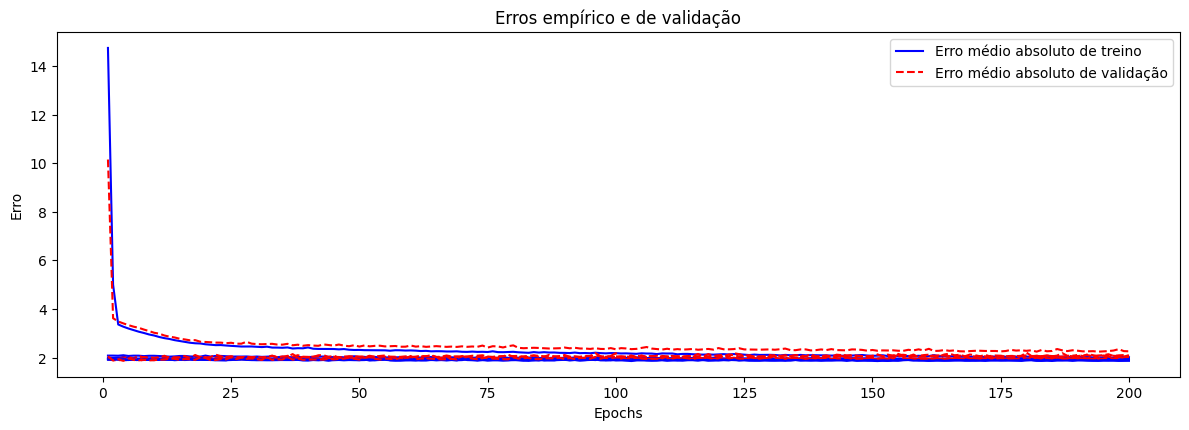

In [11]:
num_model, histories = train_kfold(model, data_train, labels_train, epochs=200, batch_size=50)
plot(histories)

In [12]:
loss, mae = model.evaluate(data_test, labels_test)
print(loss, mae)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 6.7386 - mean_absolute_error: 2.0008
7.163418292999268 2.041203022003174


In [18]:
len(graph_lines)*3/60

179.35